In [148]:
# import pyTorch
import torch
from torch import nn

# import torchVision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# import DataLoader
from torch.utils.data import DataLoader

# import other packages
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer 
from tqdm.auto import tqdm

In [7]:
# Load MNIST dataset
trainData = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

testData = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

In [8]:
# Check data
image, label = trainData[0]
image.shape

torch.Size([1, 28, 28])

In [12]:
len(trainData.data), len(trainData.targets), len(testData.data), len(testData.targets)

(60000, 60000, 10000, 10000)

In [14]:
classNames = trainData.classes
classNames

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Text(0.5, 1.0, '5')

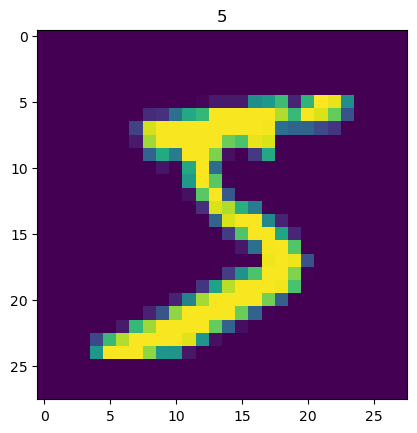

In [16]:
# Visualize image
plt.imshow(image.squeeze())
plt.title(label)

In [18]:
# Prepare data loader
batchSize = 1024
trainDataLoader = DataLoader(trainData, batch_size= batchSize, shuffle = True)
testDataLoader = DataLoader(testData, batch_size = batchSize, shuffle = True)

print(f"DataLoader for training set: {len(trainDataLoader)} batches of {batchSize}")
print(f"DataLoader for test set: {len(testDataLoader)} batches of {batchSize}")

DataLoader for training set: 59 batches of 1024
DataLoader for test set: 10 batches of 1024


Text(0.5, 1.0, '8 - eight')

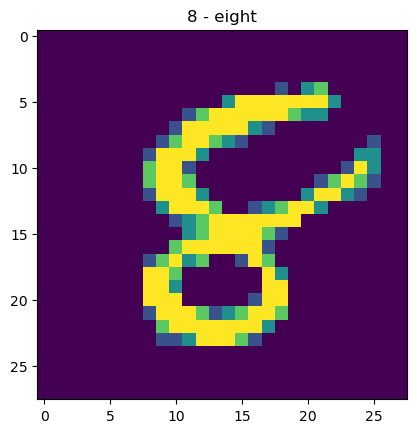

In [20]:
# Visualize the first one in the train dataLoader
trainFeaturesBatch, trainLabelsBatch = next(iter(trainDataLoader))
img, lbl = trainFeaturesBatch[0], trainLabelsBatch[0]
plt.imshow(img.squeeze())
plt.title(classNames[lbl])

In [22]:
# Accuracy function
def predAccuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Timing function
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Training loop function
def train_step(model_instance : torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer, 
               acc_fn, 
               device: torch.device):
    
    train_loss, train_acc = 0,0
    model_instance.to(device)
    model_instance.train()
    
    for batch, (x,y) in enumerate(data_loader):
        x,y = x.to(device), y.to(device)    
        
        train_pred = model_instance(x)
        
        loss= loss_fn(train_pred,y)
        train_loss += loss
        train_acc += acc_fn(y,train_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%\n")

# Test loop function
def test_step(model_instance : torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               acc_fn, 
               device: torch.device):
    
    test_loss, test_acc = 0,0
    model_instance.to(device)
    model_instance.eval()
    
    with torch.inference_mode():
        for x,y in data_loader:
            x,y = x.to(device), y.to(device)
            
            test_pred = model_instance(x)
            
            test_loss +=loss_fn(test_pred,y)
            test_acc += acc_fn(y,test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

# Model evaluation summary function
def eval_model(model_instance: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device: torch.device):

    loss, acc = 0, 0
    model_instance.to(device)
    model_instance.eval()
    
    with torch.inference_mode():
        for x, y in data_loader:
            x,y = x.to(device), y.to(device)
            
            y_pred = model_instance(x)
            
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y,y_pred.argmax(dim=1)) 
            
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model_instance.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}



In [24]:
# Create model-1 (CNN): tinyVGG
class MNISTModelv1(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [36]:
device = "cpu"
input_shape = 1
hidden_shape = 10
output_shape = len(classNames)

# Create a model-1 instance and train it. Afterwards make predictions with it.
model1_CNN_cpu_batch512 = MNISTModelv1(input_shape, hidden_shape, output_shape)

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1_CNN_cpu_batch512.parameters(), lr=0.1)

epochs = 10

train_time_start_model1 = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=trainDataLoader, 
        model_instance=model1_CNN_cpu_batch512, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        acc_fn=predAccuracy,
        device=device
    )

train_time_end_model1 = timer()
total_train_time_model1 = print_train_time(start=train_time_start_model1,
                                           end=train_time_end_model1,
                                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.28910 | Train accuracy: 17.21%

Epoch: 1
---------
Train loss: 2.04447 | Train accuracy: 42.89%

Epoch: 2
---------
Train loss: 0.44869 | Train accuracy: 88.06%

Epoch: 3
---------
Train loss: 0.19231 | Train accuracy: 94.27%

Epoch: 4
---------
Train loss: 0.16133 | Train accuracy: 95.19%

Epoch: 5
---------
Train loss: 0.14042 | Train accuracy: 95.74%

Epoch: 6
---------
Train loss: 0.11399 | Train accuracy: 96.60%

Epoch: 7
---------
Train loss: 0.10240 | Train accuracy: 96.86%

Epoch: 8
---------
Train loss: 0.09794 | Train accuracy: 96.99%

Epoch: 9
---------
Train loss: 0.08915 | Train accuracy: 97.31%

Train time on cpu: 119.478 seconds


In [38]:
# Get model1 results 
model1_CNN_cpu_batch512_results = eval_model(
    model_instance=model1_CNN_cpu_batch512,
    data_loader=testDataLoader,
    loss_fn=loss_fn,
    accuracy_fn=predAccuracy,
    device = device)
model1_CNN_cpu_batch512_results

{'model_name': 'MNISTModelv1',
 'model_loss': 0.07225783169269562,
 'model_acc': 97.7586894132653}

In [150]:
device = "cuda"
input_shape = 1
hidden_shape = 100
output_shape = len(classNames)

# Create a model-2 instance and train it. Afterwards make predictions with it.
model1_CNN_gpu_batch512 = MNISTModelv1(input_shape, hidden_shape, output_shape)

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1_CNN_gpu_batch512.parameters(), lr=0.1)

epochs = 30

train_time_start_model2 = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=trainDataLoader, 
        model_instance=model1_CNN_gpu_batch512, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        acc_fn=predAccuracy,
        device=device
    )

train_time_end_model2 = timer()
total_train_time_model2 = print_train_time(start=train_time_start_model2,
                                           end=train_time_end_model2,
                                           device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.24903 | Train accuracy: 27.58%

Epoch: 1
---------
Train loss: 1.40614 | Train accuracy: 62.03%

Epoch: 2
---------
Train loss: 0.24085 | Train accuracy: 92.60%

Epoch: 3
---------
Train loss: 0.15550 | Train accuracy: 95.28%

Epoch: 4
---------
Train loss: 0.18931 | Train accuracy: 94.30%

Epoch: 5
---------
Train loss: 0.10314 | Train accuracy: 96.87%

Epoch: 6
---------
Train loss: 0.08735 | Train accuracy: 97.31%

Epoch: 7
---------
Train loss: 0.07909 | Train accuracy: 97.60%

Epoch: 8
---------
Train loss: 0.06997 | Train accuracy: 97.86%

Epoch: 9
---------
Train loss: 0.06600 | Train accuracy: 97.96%

Epoch: 10
---------
Train loss: 0.06022 | Train accuracy: 98.12%

Epoch: 11
---------
Train loss: 0.05556 | Train accuracy: 98.29%

Epoch: 12
---------
Train loss: 0.05165 | Train accuracy: 98.39%

Epoch: 13
---------
Train loss: 0.15914 | Train accuracy: 96.23%

Epoch: 14
---------
Train loss: 0.06483 | Train accuracy: 98.04%

Epoch: 15
---------


In [152]:
# Get model2 results 
model1_CNN_gpu_batch512_results = eval_model(
    model_instance=model1_CNN_gpu_batch512,
    data_loader=testDataLoader,
    loss_fn=loss_fn,
    accuracy_fn=predAccuracy,
    device = device)
model1_CNN_gpu_batch512_results

{'model_name': 'MNISTModelv1',
 'model_loss': 0.03123348392546177,
 'model_acc': 99.01905293367346}

In [114]:
#compare_results = pd.DataFrame([model1_CNN_cpu_batch512_results,
#                                model1_CNN_gpu_batch512_results])
#compare_results["training_time"] = [total_train_time_model1 ,
#                                    total_train_time_model2]
#compare_results


In [116]:
# Visualize results
#compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
#plt.xlabel("accuracy (%)")
#plt.ylabel("model")

In [154]:
# Make predictions on the Kaggle test set
import os
import numpy as np

dir = os.getcwd() + '\\data'
dfTest = pd.read_csv(dir+'\\test.csv')
dfTest = np.array(dfTest)
dfTest.shape

(28000, 784)

In [156]:
xTest = (dfTest/255.).reshape(28000,1,28,28)
xTest = torch.tensor(xTest.astype(np.float32)).to(device)
xTest[0].shape

torch.Size([1, 28, 28])

In [158]:
batchSize = 1000
dataLoader = DataLoader(xTest, batch_size= batchSize, shuffle = False)

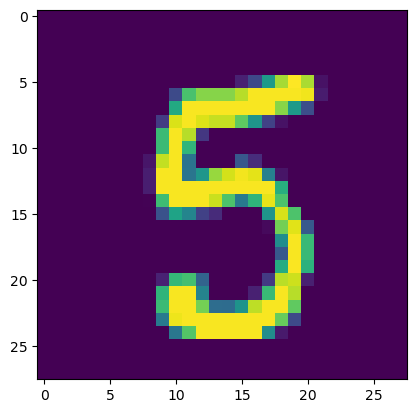

In [162]:
# Visualize the first one in the train dataLoader
FeaturesBatch= next(iter(dataLoader))
img = FeaturesBatch[10].to("cpu")
plt.imshow(img.squeeze())

In [164]:
img.shape

torch.Size([1, 28, 28])

In [166]:
pred_probs = []
model1_CNN_gpu_batch512.eval()
with torch.inference_mode():
    for x in dataLoader:
        preds = model1_CNN_gpu_batch512(x).argmax(dim=1)
        pred_probs.append(preds.cpu())

In [168]:
finalPreds = []
for torch in pred_probs:
    finalPreds.append(torch.data.tolist())
pred = [x for xs in finalPreds for x in xs]

submission_df = pd.DataFrame({"ImageId": np.arange(1,len(pred)+1), "Label": pred})
submission_df.to_csv("submissionCNNpyTorch.csv", index=False)